In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint

In [2]:
# Set a seed for reproducability of the results 
random.seed(42)

Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks
You will investigate the five hallmarks of stochastic SIR dynamics using an event drive
SIR model:
1. variability;
2. negative co-variances;
3. increased transients;
4. stochastic resonance;
5. extinctions.


In [3]:
def sir(variables, t, beta, gamma, mu):
    S = variables[0]
    I = variables[1]
    R = variables[2]

    N = S + I + R

    dSdt = mu * N - beta * I * S / N - (mu * S)
    dIdt = beta * I * S / N - (gamma + mu) * I
    dRdt = gamma * I - mu * R

    return([dSdt, dIdt, dRdt])

Implement Gillespies algorithm
Write some python code to implement Gillespies Algorithm (GA)
1. You should define the
events and the rates of each event for the SIR model. Keep in mind it may be insightful
to compare the GA stochastic simulation with an equivalent deterministic ODE model.

In [4]:
def Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu, noise_intensity=1):
    S_init = N_init - I_init - R_init
    beta = R0 * gamma
    # Initialize lists with initial conditions
    S = [S_init]
    I = [I_init]
    R = [R_init]
    t = [0]

    run_count = 0
    while t[-1] < tend and (S[-1] + I[-1] + R[-1] >= 1):
        # Get Population
        N = S[-1] + I[-1] + R[-1]

        # Get the probabilities: [birth, transmission, recovery, 3x death]
        props = [mu * N, beta * I[-1] * S[-1] / N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]

        # Get sum of probability
        prop_sum = sum(props)

        try:
            # Determine the time until the next event occurs based on the probability sum.
            tau = np.random.exponential(scale=1 / prop_sum)

            # Append new time point only once
            t_new = t[-1] + tau

            # Generate random number    
            rand = random.uniform(0, 1)

            # Determine which event occurs based on the random number and probabilities
            if rand * prop_sum <= props[0]:
                # Birth event
                S_new = S[-1] + 1
                I_new = I[-1]
                R_new = R[-1]
            elif rand * prop_sum <= props[0] + props[1]:
                # Transmission event
                S_new = S[-1] - 1
                I_new = I[-1] + 1
                R_new = R[-1]
            elif rand * prop_sum <= props[0] + props[1] + props[2]:
                # Recovery event
                S_new = S[-1]
                I_new = I[-1] - 1
                R_new = R[-1] + 1
            elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3]:
                # Death event in the susceptible compartment
                S_new = S[-1] - 1
                I_new = I[-1]
                R_new = R[-1]
            elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3] + props[4]:
                # Death event in the infected compartment
                S_new = S[-1]
                I_new = I[-1] - 1
                R_new = R[-1]
            else:
                # Death event in the recovered compartment
                S_new = S[-1]
                I_new = I[-1]
                R_new = R[-1] - 1

            # Append the new values to the lists
            S.append(S_new)
            I.append(I_new)
            R.append(R_new)
            t.append(t_new)

        except ZeroDivisionError:
            print(f"ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count {run_count}")
            run_count += 1
            if run_count > 10:
                print("Stochastic extinction is happening too often, choose different parameters")
                break

    return S, I, R, t

In [5]:
# Initial conditions
N_init = 1000
I_init = 10
R_init = 0
t = 0

# Parameters
R0 = 3
gamma = 0.1
mu = 0.05
tend = 300

In [6]:
# Initialization and simulation
n_runs = 10
results = []

max_length = 0  # Initialize max_length outside the loop

for i in range(n_runs):
    S, I, R, t = Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu)

    # Update max_length if needed
    max_length = max(max_length, len(t))

    # Append results without interpolation for now
    results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

# Interpolate results to have consistent time points
interp_t = np.linspace(0, tend, max_length)
interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in results])
interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in results])
interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in results])

# Calculate mean after interpolation
mean_S = np.mean(interp_S, axis=0)
mean_I = np.mean(interp_I, axis=0)
mean_R = np.mean(interp_R, axis=0)

In [7]:
def RMSE(x, y):
    if not len(x) == len(y):
        raise ValueError("x and y must be of same length")
    return np.sqrt(np.mean(np.square(x - y)))

In [8]:
S_init = N_init - I_init - R_init
beta = R0 * gamma
y0 = [S_init, I_init, R_init]
y = odeint(sir, y0, t, args=(beta, gamma, mu))

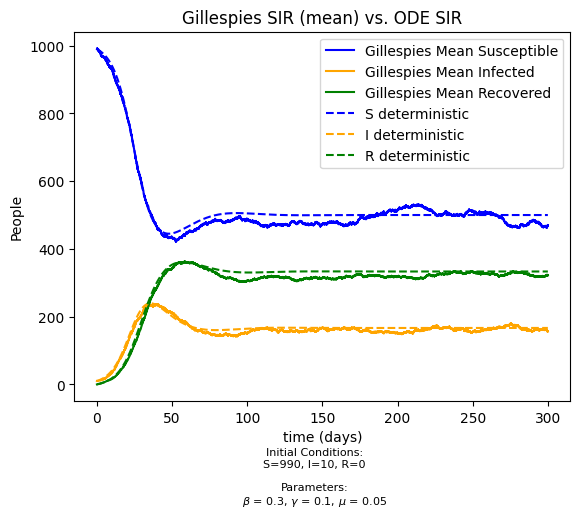

In [9]:
# plot the Mean of Gillespies Algorithm
plt.plot(interp_t, mean_S, label='Gillespies Mean Susceptible', color='blue')
plt.plot(interp_t, mean_I, label='Gillespies Mean Infected', color='orange')
plt.plot(interp_t, mean_R, label='Gillespies Mean Recovered', color='green')

# Plot deterministic SIR
plt.plot(t,y[:,0], label = "S deterministic", color='blue', ls='--')
plt.plot(t,y[:,1], label = "I deterministic", color='orange', ls='--')
plt.plot(t,y[:,2], label = "R deterministic", color='green', ls='--')

plt.xlabel('time (days)')
plt.ylabel('People')
plt.legend()

# Include initial conditions and parameters in the figure text
figtext_str = f'Initial Conditions:\nS={S_init}, I={I_init}, R={R_init}\n\nParameters:\n$\\beta$ = {round(beta, 1)}, $\\gamma$ = {gamma}, $\\mu$ = {mu}'
plt.figtext(0.5, -0.1, figtext_str, wrap=True, horizontalalignment='center', fontsize=8)


plt.title('Gillespies SIR (mean) vs. ODE SIR')
plt.savefig('1.1. Gillespies SIR (mean) vs. deterministic SIR.png')

BONUS: You can also think about (and implement) a way to control the noise level in
the GA.

Investigate Simulation Variability and Negative Co-variance
In the first experiment you should investigate how varying the model parameters changes
the behaviour of the stochastic dynamics, in particular how they relate to variance between
runs and how they impact negative covariance between S and I. Compare the mean of
the stochastic simulations with the equivalent deterministic model output (do this for
multiple settings of the model parameters).


In [10]:
R0_values = np.linspace(1, 5, 10)
gamma = 0.1

In [11]:
# Initialization and simulation
n_runs = 10
results = []
covariances = []

max_length = 0  # Initialize max_length outside the loop

for R0 in R0_values:
    run_results = []

    for i in range(n_runs):
        S, I, R, t = Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu)

        # Update max_length if needed
        max_length = max(max_length, len(t))

        # Append results without interpolation for now
        run_results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

    results.append(run_results)
    
# Interpolate results to have consistent time points for each combination
interp_results = []

for id, run_results in enumerate(results):
    interp_t = np.linspace(0, tend, max_length)
    interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in run_results])
    interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in run_results])
    interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in run_results])

    interp_results.append((interp_S, interp_I, interp_R))

    # Calculate covariance for each beta
    cov_matrix = np.cov(interp_S.flatten(), interp_I.flatten())
    covariance_SI = cov_matrix[0, 1]

    # Store results
    covariances.append((R0_values[id], covariance_SI))

# Calculate mean after interpolation for each combination
mean_results = []

for interp_S, interp_I, interp_R in interp_results:
    mean_S = np.mean(interp_S, axis=0)
    mean_I = np.mean(interp_I, axis=0)
    mean_R = np.mean(interp_R, axis=0)

    mean_results.append((mean_S, mean_I, mean_R))

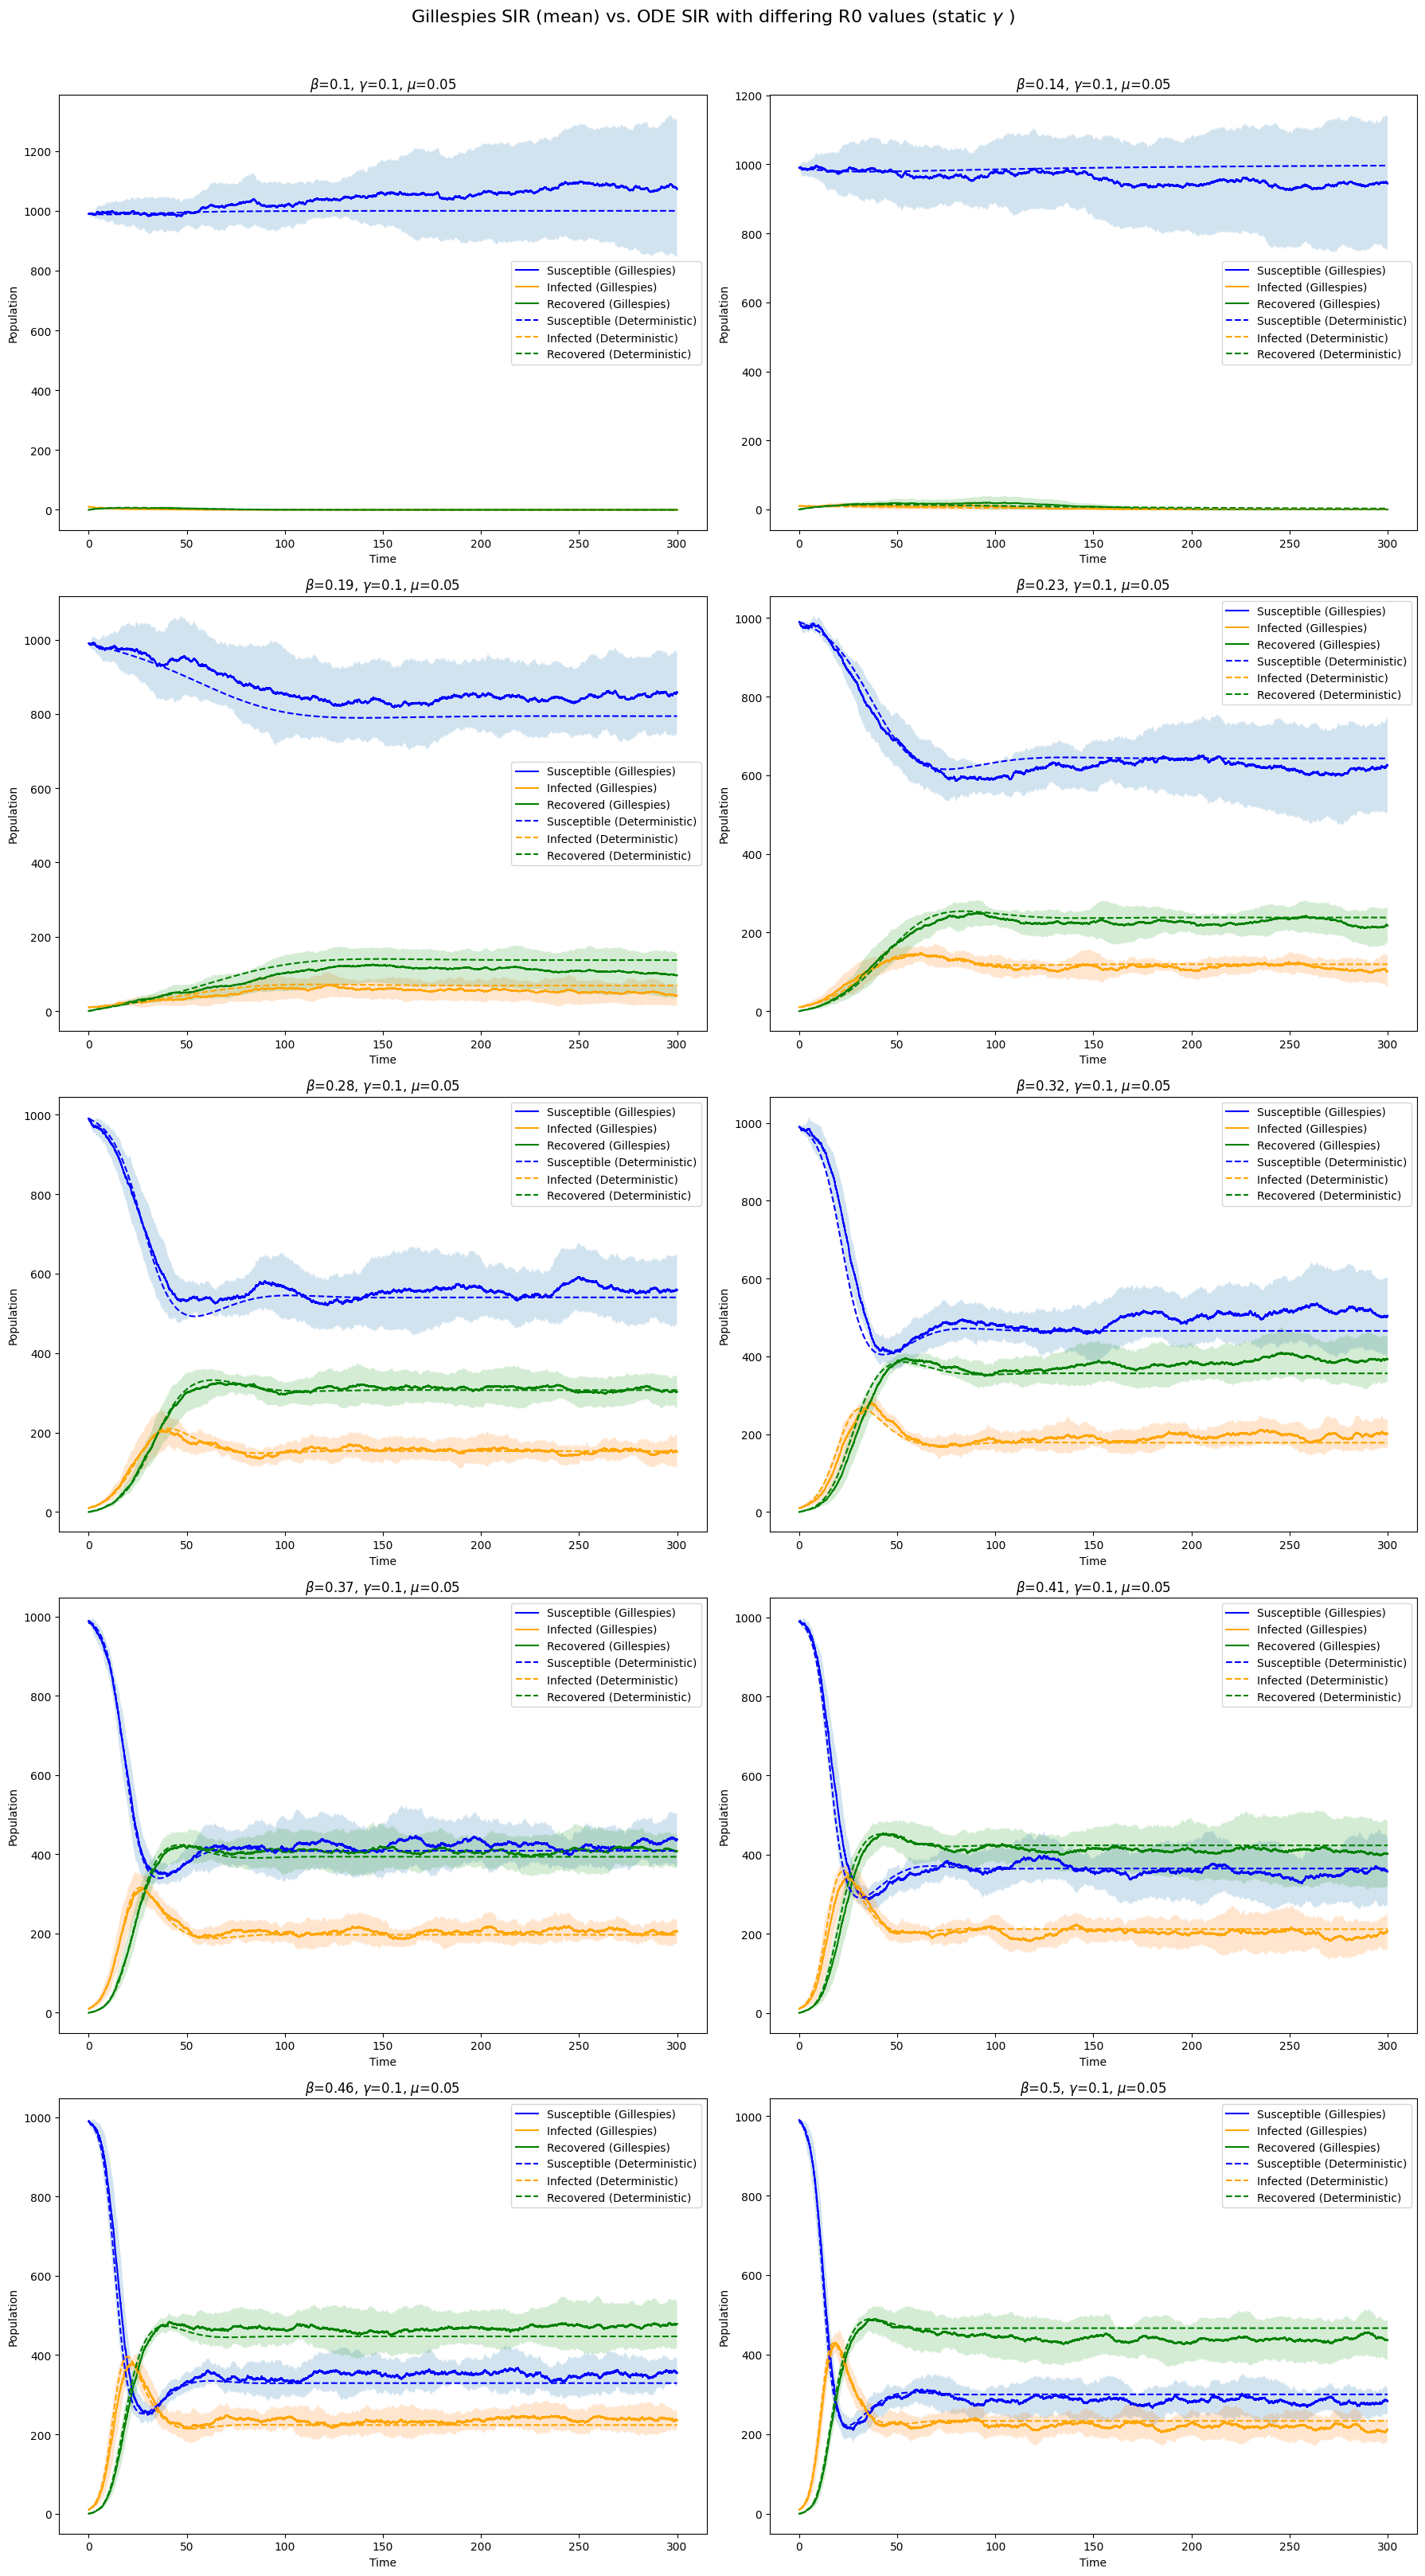

<Figure size 640x480 with 0 Axes>

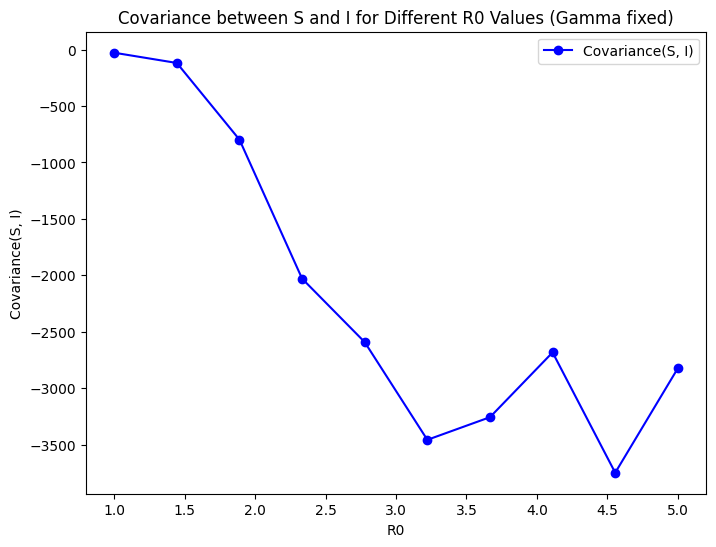

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot results for each combination
# Loop through R0 values and create subplots
plt.figure(figsize=(18, 32))
plt.suptitle('Gillespies SIR (mean) vs. ODE SIR with differing R0 values (static $\\gamma$ )', fontsize=16, y=1.01)

for idx, R0 in enumerate(R0_values):
    plt.subplot(5, 2, idx + 1)
    plt.title(f'$\\beta$={round(R0 * gamma, 2)}, $\\gamma$={gamma}, $\\mu$={mu}')
    plt.xlabel('Time')
    plt.ylabel('Population')

    mean_S, mean_I, mean_R = mean_results[idx]
    std_S = np.std(interp_results[idx][0], axis=0)
    std_I = np.std(interp_results[idx][1], axis=0)
    std_R = np.std(interp_results[idx][2], axis=0)

    plt.plot(interp_t, mean_S, label='Susceptible (Gillespies)', color='blue')
    plt.plot(interp_t, mean_I, label='Infected (Gillespies)', color='orange')
    plt.plot(interp_t, mean_R, label='Recovered (Gillespies)', color='green')

    plt.fill_between(interp_t, mean_S - std_S, mean_S + std_S, alpha=0.2)
    plt.fill_between(interp_t, mean_I - std_I, mean_I + std_I, alpha=0.2)
    plt.fill_between(interp_t, mean_R - std_R, mean_R + std_R, alpha=0.2)

    S_init = N_init - I_init - R_init
    beta = R0 * gamma
    y0 = [S_init, I_init, R_init]
    y = odeint(sir, y0, t, args=(beta, gamma, mu))
    plt.plot(t, y[:, 0], label='Susceptible (Deterministic)', color='blue', linestyle='--')
    plt.plot(t, y[:, 1], label='Infected (Deterministic)', color='orange', linestyle='--')
    plt.plot(t, y[:, 2], label='Recovered (Deterministic)', color='green', linestyle='--')

    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig('1.2. Gillespies SIR (mean) vs. ODE SIR with differing R0 values.png')

# Extract data for scatter plot
R0_vals = [cov[0] for cov in covariances]
covariance_values = [cov[1] for cov in covariances]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.plot(R0_vals, covariance_values, color='blue', label='Covariance(S, I)', marker='o')
plt.xlabel('R0')
plt.ylabel('Covariance(S, I)')
plt.title('Covariance between S and I for Different R0 Values (Gamma fixed)')
plt.legend()
plt.show()
plt.savefig('1.2. Covariance Gillespies SIR (mean) vs. ODE SIR with differing R0 values.png')

## Stochastic Resonance and Increased Transients
Show how the stochastic model can induce stochastic resonance around the equilibrium
and how that resonance relates the model parameters (e.g., N, β), etc). Show some
examples of increased transients away from the deterministic equilibrium - can you show
which parameter values lead to the largest transients.


In [13]:
# Initial conditions
N_init = 1000
I_init = 10
R_init = 0
t = 0

# Parameters
R0 = 2
gamma = 0.3
mu = 0.02
noise_intensity = 0.5
tend = 300

In [14]:
# Initialization and simulation
n_runs = 10
results = []

max_length = 0  # Initialize max_length outside the loop

for i in range(n_runs):
    S, I, R, t = Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu, noise_intensity=noise_intensity)

    # Update max_length if needed
    max_length = max(max_length, len(t))

    # Append results without interpolation for now
    results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

# Interpolate results to have consistent time points
interp_t = np.linspace(0, tend, max_length)
interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in results])
interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in results])
interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in results])

# Calculate mean after interpolation
mean_S = np.mean(interp_S, axis=0)
mean_I = np.mean(interp_I, axis=0)
mean_R = np.mean(interp_R, axis=0)


In [15]:
S_init = N_init - I_init - R_init
beta = R0 * gamma
y0 = [S_init, I_init, R_init]
y = odeint(sir, y0, t, args=(beta, gamma, mu))

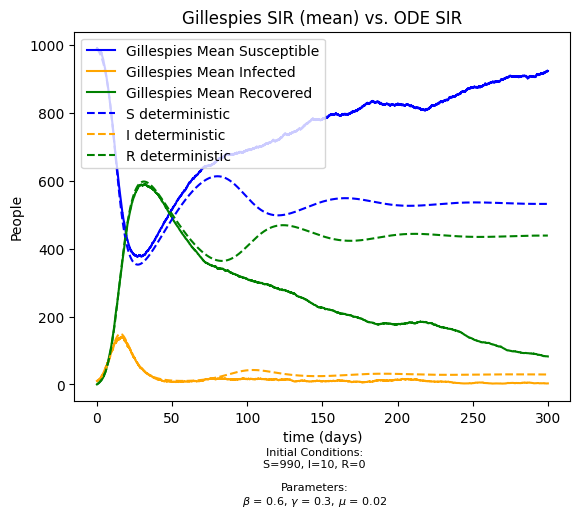

In [16]:
# Plotting
# plot the Mean of Gillespies Algorithm
plt.plot(interp_t, mean_S, label='Gillespies Mean Susceptible', color='blue')
plt.plot(interp_t, mean_I, label='Gillespies Mean Infected', color='orange')
plt.plot(interp_t, mean_R, label='Gillespies Mean Recovered', color='green')

# Plot deterministic SIR
plt.plot(t,y[:,0], label = "S deterministic", color='blue', ls='--')
plt.plot(t,y[:,1], label = "I deterministic", color='orange', ls='--')
plt.plot(t,y[:,2], label = "R deterministic", color='green', ls='--')

plt.xlabel('time (days)')
plt.ylabel('People')
plt.legend()

# Include initial conditions and parameters in the figure text
figtext_str = f'Initial Conditions:\nS={S_init}, I={I_init}, R={R_init}\n\nParameters:\n$\\beta$ = {round(beta, 1)}, $\\gamma$ = {gamma}, $\\mu$ = {mu}'
plt.figtext(0.5, -0.1, figtext_str, wrap=True, horizontalalignment='center', fontsize=8)


plt.title('Gillespies SIR (mean) vs. ODE SIR')
plt.savefig('1.3. Gillespies SIR (mean) vs. deterministic SIR.png')

### Extinction events and Critical Community Size
In the lectures we have discussed the possibility of extinction of the virus even when
R0 > 1 in closed populations. Design an experiment to show how varying R0 impacts
the extinction process. Keep in mind that in the closed system randomness will always
eventually lead to extinction. Now look at how the extinction events are impacted by
the population size. Find a way to show how the two parameters R0 and N interact to
impact the extinction process.

In [25]:
# Initial conditions
N_init = 1000
I_init = 5
R_init = 0
tend = 100

# Parameters for simulation
gamma = 0.1
mu = 0.02

In [26]:
# Range of R0 values
R0_values = np.linspace(0.5, 3.0, 10)

# Number of simulations for each R0 value
num_simulations = 100

# List to store probability of extinction for each R0 value
extinction_probabilities = []

for R0 in R0_values:
    extinction_count_total = 0

    for _ in range(num_simulations):
        S, I, R, t = Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu)

        # Check if the last element of the infected compartment (I) is zero
        if I[-1] == 0:
            extinction_count_total += 1

    extinction_probability = extinction_count_total / num_simulations
    extinction_probabilities.append(extinction_probability)

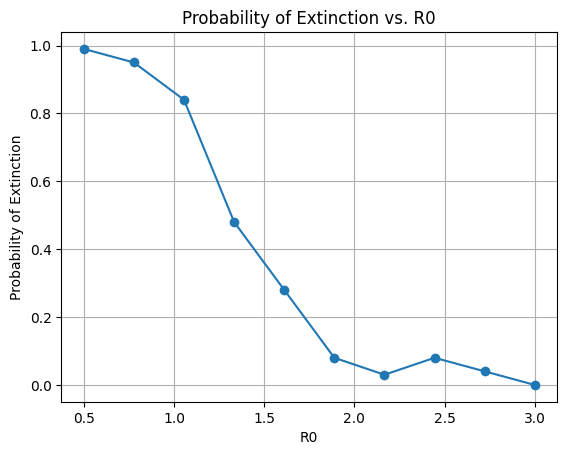

<Figure size 640x480 with 0 Axes>

In [27]:
# Plotting
plt.plot(R0_values, extinction_probabilities, marker='o')
plt.title('Probability of Extinction vs. R0')
plt.xlabel('R0')
plt.ylabel('Probability of Extinction')
plt.grid(True)
plt.show()
plt.savefig('1.4. Probability of Extinction vs. R0.png')

In [28]:
# Initial conditions
R0 = 3
I_init = 10
R_init = 0
tend = 100

# Parameters for simulation
gamma = 0.1
mu = 0.02

In [29]:
# Range of N_init values
N_init_values = np.linspace(10, 200, 10, dtype=int)

# Number of simulations for each N_init value
num_simulations = 100

# List to store probability of extinction for each N_init value
extinction_probabilities = []

for N_init in N_init_values:
    extinction_count_total = 0

    for _ in range(num_simulations):
        S, I, R, t = Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu)

        # Check if the last element of the infected compartment (I) is zero
        if I[-1] == 0:
            extinction_count_total += 1

    extinction_probability = extinction_count_total / num_simulations
    extinction_probabilities.append(extinction_probability)

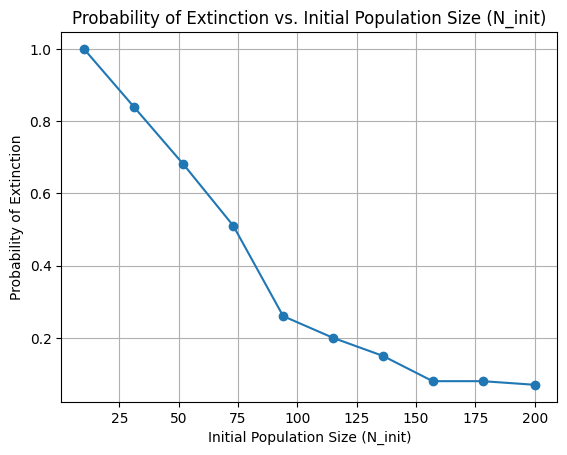

<Figure size 640x480 with 0 Axes>

In [30]:
# Plotting
plt.plot(N_init_values, extinction_probabilities, marker='o')
plt.title('Probability of Extinction vs. Initial Population Size (N_init)')
plt.xlabel('Initial Population Size (N_init)')
plt.ylabel('Probability of Extinction')
plt.grid(True)
plt.show()
plt.savefig('1.4. Probability of Extinction vs. Initial Population Size (N_init).png')

In [31]:
# Create meshgrid for R0 and N_init
R0_mesh, N_init_mesh = np.meshgrid(R0_values, N_init_values)

# Initialize array for storing probability of extinction
extinction_probabilities = np.zeros_like(R0_mesh, dtype=float)

In [32]:
# Number of simulations for each combination of R0 and N_init
num_simulations = 100

# Perform simulations
for i, R0 in enumerate(R0_values):
    for j, N_init in enumerate(N_init_values):
        extinction_count_total = 0

        for _ in range(num_simulations):
            S, I, R, t = Gillespies(N_init, I_init, R_init, tend, R0, gamma, mu)

            # Check if the last element of the infected compartment (I) is zero
            if I[-1] == 0:
                extinction_count_total += 1

        extinction_probability = extinction_count_total / num_simulations
        extinction_probabilities[j, i] = extinction_probability


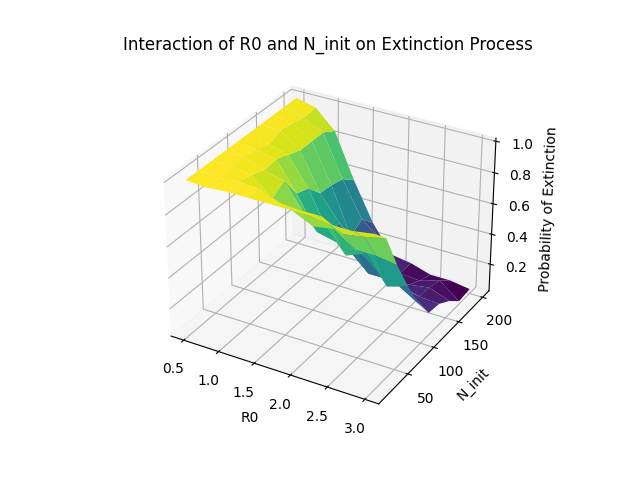

In [33]:
# Enable interactive mode
%matplotlib widget 

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(R0_mesh, N_init_mesh, extinction_probabilities, cmap='viridis')

ax.set_xlabel('R0')
ax.set_ylabel('N_init')
ax.set_zlabel('Probability of Extinction')
ax.set_title('Interaction of R0 and N_init on Extinction Process')

# Display the plot
plt.show()
plt.savefig('1.4. Interaction of R0 and N_init on Extinction Process.png')